In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from util import *
from sklearn.preprocessing import StandardScaler
import time
from joblib import Memory
import pickle

%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


C:\Users\up\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
memory = Memory(cachedir='cache')

In [4]:
vehicle_files = traverse_train_dataset('vehicles', ['GTI_Far', 'GTI_Left', 'GTI_MiddleClose', 'GTI_Right', 'KITTI_extracted'])
nonvehicle_files = traverse_train_dataset('non-vehicles', ['Extras', 'GTI'])

In [5]:
data_look(vehicle_files, nonvehicle_files)

{'data_type': dtype('float32'),
 'image_shape': (64, 64, 3),
 'n_cars': 8792,
 'n_notcars': 8968}

In [6]:
cars = vehicle_files
notcars = nonvehicle_files

In [8]:
# definition of default params used by the function across the workbook

params = dict(
    conv = cv2.COLOR_RGB2YCrCb,
    orient = 9, 
    spatial_size = (32, 32),
    pix_per_cell = 8,
    cell_per_block = 2,
    hist_bins = 32
)

ystart = 400
ystop = 656

In [9]:
t = time.time()

extract_params = {
    **params, **dict(
        hog_feat=True,
        spatial_feat=True,
        hist_feat=True)
}

car_features = extract_features(cars, **extract_params)
notcar_features = extract_features(notcars, **extract_params)

t2 = time.time()
print(round(t2 - t, 2), 'Seconds to extract HOG features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64) 
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

t = time.time()
   
svc, svc_acc = train_svc(scaled_X, y)
    
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc_acc, 4))


________________________________________________________________________________
[Memory] Calling util.extract_features...
extract_features(array(['vehicles/GTI_Far\\image0000.png', ...,
       'vehicles/KITTI_extracted\\999.png'], 
      dtype='<U38'), pix_per_cell=8, hog_feat=True, orient=9, spatial_size=(32, 32), hist_feat=True, cell_per_block=2, spatial_feat=True, conv=37, hist_bins=32)
________________________________________________extract_features - 89.5s, 1.5min
157.35 Seconds to extract HOG features...
________________________________________________________________________________
[Memory] Calling util.train_svc...
train_svc(array([[ 1.37974 , ...,  0.056568],
       ..., 
       [-0.615062, ...,  1.124254]]), 
array([ 1., ...,  0.]))
________________________________________________________train_svc - 7.8s, 0.1min
9.43 Seconds to train SVC...
Test Accuracy of SVC =  0.9899


In [11]:
pickle.dump(svc, open('svc.p', 'wb'))
pickle.dump(X_scaler, open('scaler.p', 'wb'))

In [54]:
class FrameState():
    history_size = None
    thresh = None
    history_boxes = []
    heat_layer = False
    find_cars_params = {}
    
    def __init__(self, history_size=1, thresh=0, heat_layer=False, **kwargs):
        self.history_boxes = []
        self.history_size = history_size
        self.thresh = thresh
        self.heat_layer = heat_layer
        self.find_cars_params = kwargs
        
    def labels_to_boxes(self, labels):
        boxes = [] 
        for car_number in range(1, labels[1]+1):
            nonzero = (labels[0] == car_number).nonzero()

            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])

            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            boxes.append(bbox)

        return boxes
    
    def merge_intersect_x(self, bb):
        if len(bb) == 0:
            return bb
        
        saved = list(bb[0])
        for st, en in sorted([sorted(t) for t in bb]):
            if st[0] <= saved[1][0]:
                saved[1] = (max(saved[1][0], en[0]), max(saved[1][1], en[1]))
            else:
                yield tuple(saved)
                saved[0] = st
                saved[1] = en

        yield tuple(saved)
    
    
    def __call__(self, image):
        frame_boxes = find_cars_multiscaled(image, **self.find_cars_params)
        self.history_boxes.append(frame_boxes)
        
        if len(self.history_boxes) > self.history_size:
            del(self.history_boxes[0])
        
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        heat_thresh = np.copy(heat)
        
        nonzero_boxes = [b for b in self.history_boxes if len(b) > 0]
        if len(nonzero_boxes) > 0:
            all_boxes = np.concatenate(nonzero_boxes)
            if len(all_boxes) > 0:
                heat = add_heat(heat, all_boxes)

            if self.thresh > 0:
                heat_thresh = apply_threshold(heat, self.thresh)    
    
        labels = label(heat_thresh)
        
        boxes = self.labels_to_boxes(labels)
        boxes = [((b[0][0] - 25, b[0][1] - 25), (b[1][0] + 25, b[1][1] + 25)) for b in boxes]
        boxes = list(self.merge_intersect_x(boxes))
  
        # skip some small after merging
        boxes = [b for b in boxes if (b[1][0] - b[0][0] - 50) > 50 and (b[1][0] - b[0][0] - 50) > 50]
        
        for bbox in boxes:
            cv2.rectangle(image, bbox[0], bbox[1], (0,0,255), 6)
        
        if self.heat_layer:
            heat *= 10
            h2 = np.clip(np.dstack((heat, heat, heat)).astype(np.uint8), 0, 255)
            image = cv2.addWeighted(image, 1, h2, 1, 0)
    
        return image


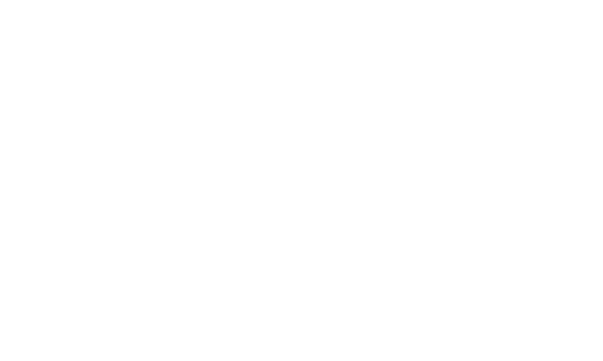

In [55]:
from IPython.display import clear_output

state = FrameState(5, 9, False, scales=scale_steps(0.5, 2, 0.5), **find_cars_params)

vid = cv2.VideoCapture("shadows.mp4")

try:
    while(True):
        ret, frame = vid.read()
        if not ret:
            vid.release()
            break
            
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        axis('off')

        result_frame = state(frame)
        
        plt.imshow(result_frame)       
        
        show()

        #clear_output(wait=False)
        clear_output(wait=True)
        
except KeyboardInterrupt:
    vid.release()

In [56]:
from moviepy.editor import VideoFileClip

state = FrameState(5, 9, False, scales=scale_steps(0.5, 2, 0.5), **find_cars_params)

test_output = 'project_video_result.mp4'
clip = VideoFileClip('project_video.mp4')
fl_clip = clip.fl_image(state)
%time fl_clip.write_videofile(test_output, audio=False)

C:\Users\up\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\filter\__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '
C:\Users\up\Anaconda3\envs\carnd-term1\lib\site-packages\moviepy\audio\io\readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))



MoviePy: building video file project_video_result.mp4
----------------------------------------

Writing video into project_video_result.mp4
Done writing video in project_video_result.mp4 !                           
Your video is ready !
Wall time: 1h 11min 31s
